# Plot Processing

The plot of the movie is certainly a key element in its final quality. Thus we will try to comes with summary features.

We will base our analysis on the BOW matrix, which is constructed in the following way:
- Preprocess plots: tokenization + casefolding + stopwords and Named Entity removal + lemmatization
- BOW creation
- BOW matrix creation

Then we will extract the following features:
- Odds ratio computation in order to capture terms that are more frequent in popular (high ratio) or unpopular (low ratio) movies.
- LDA topic extraction, to add a second layer of potential topic but more coarsed and dataset tailored.

## Packages

In [6]:
# Global packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# ML models
from sklearn.decomposition import LatentDirichletAllocation
# Sparse matrix
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
from scipy.sparse import load_npz

## Load Global data

In [19]:
movie_df = pd.read_pickle("../../data/post_processing/movie_df.pkl")
is_of_type_df = pd.read_pickle("../../data/post_processing/is_of_type_df.pkl")

## Load Locally

The processing of the dataset takes some time. Thus you can load directly the following files that will save you the cost of the preprocessing.

Once done you can directly jump to the Odds Ratio section.

In [8]:
# Load data
movies_with_plot_df = pd.read_pickle("../../data/post_processing/plot_df.pkl")
BOW_matrix = load_npz("../../data/post_processing/BOW_matrix.npz")
with open("../../data/post_processing/BOW_mapping.pkl", 'rb') as handle:
    BOW_dict = pickle.load(handle)
reversed_BOW_dict = {v:k for k,v in BOW_dict.items()}

## Full Pipeline
### Plot Preprocessing

In [4]:
# imports 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Tokenize
movies_with_plot_df = pd.DataFrame(movie_df[~movie_df["plot"].isna()]["plot"])
movies_with_plot_df["tokenized"] = movies_with_plot_df["plot"].apply(tokenizer.tokenize)
movies_with_plot_df.head(3)

,plot,tokenized
movie_id,,
975900,"Set in the second half of the 22nd century, th...","[Set, in, the, second, half, of, the, 22nd, ce..."
261236,"Eva, an upper class housewife, becomes frustra...","[Eva, an, upper, class, housewife, becomes, fr..."
171005,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,"[Plot, dateAct, 1Act, 2Act, 3Act, 4Act, 5, Fin..."


In [ ]:
# POS + NER
def extract_ne(token_list: list, entity_list=["PERSON"]) -> set:
    """
    """
    entity_set = set(entity_list)
    tags = nltk.pos_tag(token_list)
    tree = nltk.ne_chunk(tags, binary=False)
    return set(
        " ".join(i[0] for i in t)
        for t in tree
        if hasattr(t, "label") and t.label() in entity_set
     )
movies_with_plot_df["NER"] = movies_with_plot_df["tokenized"].apply(extract_ne)

In [ ]:
# Add the NER to the stop words because they carry too noisy information 
for row_id, row_data in movies_with_plot_df["NER"].apply(lambda l: set(l)).iteritems():
    stop_words = stop_words.union(row_data)

In [ ]:
# Stopwords and Casefolding
movies_with_plot_df["no_stopwords"] = movies_with_plot_df["tokenized"].apply(
    lambda l: [s.casefold() for s in l if s.casefold() not in stop_words and s not in stop_words])
movies_with_plot_df.head(3)

In [ ]:
# Lemmatize
movies_with_plot_df["lemmatized"] = movies_with_plot_df["no_stopwords"].apply(
    lambda l: [lemmatizer.lemmatize(s) for s in l])
movies_with_plot_df.head(3)

### BOW creation

In [ ]:
BOW = set()
for row_id, row_data in movies_with_plot_df["lemmatized"].apply(lambda l: set(l)).iteritems():
    BOW = BOW.union(row_data)

### BOW Matrix

In [ ]:
def BOW_mapping(words_list: list, BOW_dict: dict) -> dict:
    """
    Map the BOW for each plot to its encoding in row id and number of occurences.
    
    :param words_list: List of the words contained in the plot (BOW).
    :param BOW_dict: Dictionnary containing the mapping between words and ids in the BOW matrix.
    
    :return: The dictionnary with the ids of each words and their number of occurences.
    
    """
    movie_mapping = dict()
    for w in words_list:
        word_id = BOW_dict[w]
        if word_id not in movie_mapping:
            movie_mapping[word_id] = 1
        else:
            movie_mapping[word_id] += 1 
    return movie_mapping

In [ ]:
BOW_dict = dict(zip(BOW,range(len(BOW))))
reversed_BOW_dict = {v:k for k,v in BOW_dict.items()}

In [ ]:
movies_with_plot_df["encoding"] = movies_with_plot_df["lemmatized"].apply(
    lambda l: BOW_mapping(l,BOW_dict))
movies_with_plot_df.head(3)

In [ ]:
# Create sparse matrix representation
number_of_words_per_movie = movies_with_plot_df["encoding"].apply(len).reset_index()["encoding"].values
column_ids = np.array([i for i in range(len(number_of_words_per_movie)) 
                       for j in range(number_of_words_per_movie[i])])
row_ids = movies_with_plot_df["encoding"].apply(lambda d: list(d.keys()))
row_ids = row_ids.reset_index()["encoding"].agg(np.concatenate)
data = movies_with_plot_df["encoding"].apply(lambda d: list(d.values()))
data = data.reset_index()["encoding"].agg(np.concatenate)
BOW_matrix = csr_matrix((data, (column_ids,row_ids)))

In [ ]:
# Save data
movies_with_plot_df.to_pickle("../../data/post_processing/plot_df.pkl")
save_npz("../../data/post_processing/BOW_matrix.npz",BOW_matrix)
with open("../../data/post_processing/BOW_mapping.pkl", 'wb') as handle:
    pickle.dump(BOW_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Odds ratio

In [9]:
EPSILON = 1e-4 # Set to 1e-4 empirically, but idea is to have at least one occurence in all corpus
SUCCESS_THRESHOLD = 7.5

def compute_term_frequency(matrix: csr_matrix, epsilon=EPSILON, doc_freq=False, hard_clip=False):
    """
    Compute the term frequency of words in the given BOW matrix.
    
    :param matrix: Scipy sparse BOW matrix.
    :param epsilon: Smoothing parameter.
    :param doc_freq: Indicator if the term frequency should be multiplied by the doc_freq.
                     It gives more weights to terms that appear in many documents.
    :param hard_clip: Indicator if the frequency in a term should be capped to 1.
                     Similar to doc_freq, it avoid bias toward docs with lot of repetitions.
    
    :return: Numpy array containing the smoothed term frequency.
    """
    tf = np.array(matrix.sum(axis=0).tolist()[0])
    tf = (tf+EPSILON)/tf.sum()
    if hard_clip:
        capped_occurence = matrix.copy()
        capped_occurence[capped_occurence>1] = 1
        tf = np.array(capped_occurence.sum(axis=0).tolist()[0])
        tf = (tf+EPSILON)/tf.sum()
        return tf
    elif doc_freq:
        capped_occurence = matrix.copy()
        capped_occurence[capped_occurence>1] = 1
        doc_number = epsilon+np.array(capped_occurence.sum(axis=0).tolist()[0])
        return doc_number*tf
    else:
        return tf
    
def get_top_k_terms(tf_popular: np.array, tf_unpopular: np.array,
                    reversed_BOW_dictionnary: dict, k=30,
                    bad_movie=False):
    """
    Print the terms with the highest or lowest odd ratio in the data.
    
    :param tf_popular: Term frequency for popular movies.
    :param tf_unpopular: Term frequency for unpopular movies.
    :param reversed_BOW_dictionnary: Dictionnary of term index with word string.
    :param k: Number of terms to retrieve.
    :param bad_movie: Indicator if should return the lowest log odds, so best term for bad movies.
    
    """
    # Log odds
    log_odds = np.log(tf_popular/tf_unpopular)
    if bad_movie:
        log_odds = -log_odds
    top_k_ids = np.argpartition(log_odds, -k)[-k:]
    top_log_odds = sorted([(idx,log_odds[idx]) for idx in top_k_ids],key=lambda l: -l[1])
    print(f"The top {k} terms with the highest log odds are:")
    for idx, value in top_log_odds:
        print(f"\t-{reversed_BOW_dict[idx]}: {value}")

In [10]:
popular_row_ids = (movies_with_plot_df.merge(movie_df["average_rating"],how="left",on="movie_id"
                         ).reset_index()["average_rating"] > SUCCESS_THRESHOLD).values
unpopular_row_ids = ~popular_row_ids

In [11]:
# An alternative is to do an harder filtering on the movies we want to consider rather than simple
# one sided threshold.
popular_row_ids = (movies_with_plot_df.merge(movie_df["average_rating"],how="left",on="movie_id"
                         ).reset_index()["average_rating"] > 8.5).values
unpopular_row_ids = (movies_with_plot_df.merge(movie_df["average_rating"],how="left",on="movie_id"
                         ).reset_index()["average_rating"] < 4.5).values

In [12]:
# Term frequency for popular movies with smoothing term
tf_popular_movies = compute_term_frequency(BOW_matrix[popular_row_ids,:],
                                           doc_freq=False,hard_clip=False)
# Term frequecy for unpopular movies with smoothing term
tf_unpopular_movies = compute_term_frequency(BOW_matrix[unpopular_row_ids,:],
                                             doc_freq=False,hard_clip=False)

In [13]:
get_top_k_terms(tf_popular_movies,tf_unpopular_movies,reversed_BOW_dict,k=30,bad_movie=True)

The top 30 terms with the highest log odds are:
	-alien: 12.129503607433069
	-scientist: 12.007336038430578
	-monster: 11.787013502711522
	-strange: 11.772828877779922
	-zombie: 11.456159534561106
	-vampire: 11.330996522325917
	-base: 11.308523691726355
	-wood: 11.29709500896437
	-shark: 11.225636130124736
	-unfortunately: 11.213213625558257
	-animal: 11.200634859174164
	-experiment: 11.148675187753913
	-lab: 11.121646551895624
	-box: 11.121646551895624
	-stab: 11.079682411504924
	-underground: 11.05069491664842
	-talking: 11.05069491664842
	-mask: 11.035879852812323
	-expedition: 11.02084199806195
	-jungle: 10.925531969772537
	-california: 10.908724879704694
	-treasure: 10.891630475568022
	-robot: 10.874238763104135
	-dad: 10.874238763104135
	-drink: 10.856539217333
	-investigation: 10.838520744297794
	-castle: 10.838520744297794
	-sequence: 10.801479541227952
	-sheriff: 10.801479541227952
	-helicopter: 10.78243138254166


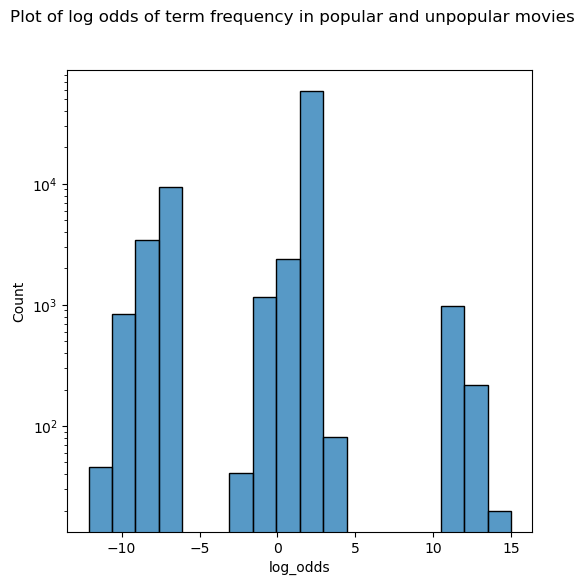

In [14]:
# Log odds
log_odds = np.log(tf_popular_movies/tf_unpopular_movies)
# Plot
fig,ax = plt.subplots(figsize=(6,6))
fig.suptitle("Plot of log odds of term frequency in popular and unpopular movies")
ax.set_xlabel("log_odds")
ax.set_yscale("log")
sns.histplot(log_odds,ax=ax);

## LDA

We creates topic generation based on plots and try to see if the results could generate good features. The idea would be to have an addition to the genre of the movie, and maybe do interaction terms. The issue is that the preliminary results give topics that are too broad most of the times, but if we want to push the analysis, we can integrate them.

In [15]:
LDA = LatentDirichletAllocation(n_components=30)
LDA_fit = LDA.fit(BOW_matrix);

In [39]:
words_nb = 10 # Number of words to be displayed per topic.
topic_nb = 4 # Best topics we want to be displayed.
test_movie_id = 1 # Id of the movies for which we want to see the LDA results.
test_movie = BOW_matrix[test_movie_id,:].reshape(1,len(BOW_dict))
top_topics = np.argpartition(LDA_fit.transform(test_movie).reshape(-1), -topic_nb)[-topic_nb:]
for topic in top_topics:
    top_words_ids = np.argpartition(LDA_fit.components_[topic,:], -words_nb)[-words_nb:]
    for word_id in top_words_ids:
        print(list(BOW_dict)[word_id], LDA_fit.components_[topic,word_id])
    print("--------")
print("\n\n",movie_df.loc[movie_df.index[test_movie_id]])
print("\n\n",is_of_type_df[is_of_type_df["movie_id"] == movie_df.index[test_movie_id]])

stage 709.2107436209355
dance 738.845409989678
love 740.1913723626755
film 1082.4606292365074
show 886.4065079430325
new 763.2069604644043
play 1139.6730194357435
band 930.0858495217976
music 1095.7106061280401
song 1076.0842157874247
--------
day 1551.6515203813044
make 1778.87011277304
mr 1604.6757636879556
friend 1894.9108453684737
show 1807.6828547594607
tell 1581.2979954589518
go 2958.6107503380126
one 1746.9092109952994
back 1818.605346331763
get 3882.857365545321
--------
car 3258.557269962315
one 3332.5055081543164
take 3375.8163106633433
back 4307.961178104664
find 6268.349691484994
go 5532.006757792141
tell 4872.836353633353
see 4025.026644776206
house 4683.112340808272
get 3750.612209849839
--------
find 3841.2778433591134
year 4080.0264254791077
tell 4670.966864107527
family 4382.35287775513
friend 4218.532478829616
home 4676.299308862989
life 5834.211979105999
father 5389.842034487537
love 5112.602927773667
mother 5400.205720982859
--------


 name                      Bru

---